In [11]:
# suppress warnings to keep the notebook clean (like HW1)
import warnings
warnings.filterwarnings("ignore")

# data / utils
import pandas as pd
import numpy as np

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report, brier_score_loss
)

# neighbors for the recommendation section
from sklearn.neighbors import NearestNeighbors

# Homework 2
## Data

In [12]:
# === DATA LOADING ===
# Update these if your instructor posted different paths.
CHURN_URL = "https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streaming.csv"
NEW_CUSTOMERS_URL = "https://raw.githubusercontent.com/ywen2021/CPSC392/refs/heads/main/Data/streamingNEW.csv"
# Optional: a favorites dataset. If not provided, we'll still do KNN on demographics/usage.
FAVORITES_URL = "https://raw.githubusercontent.com/ywen2021/CPSC392/refs/heads/main/Data/streamingFILMS.csv"

# read data
churn = pd.read_csv(CHURN_URL)
new_customers = pd.read_csv(NEW_CUSTOMERS_URL)
try:
    favorites = pd.read_csv(FAVORITES_URL)
except Exception:
    favorites = None  # if not available, we'll skip film-preference features

# quick clean
for df in (churn, new_customers):
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

# (optional) make sure plan is treated as ordered categorical if it exists
if "plan" in churn.columns:
    plan_order = pd.CategoricalDtype(categories=["T", "P", "A", "B"], ordered=True)
    churn["plan"] = churn["plan"].astype(plan_order)
    if "plan" in new_customers.columns:
        new_customers["plan"] = new_customurers_plan = new_customers["plan"].astype(plan_order)

churn.head()

,gender,age,income,monthssubbed,plan,meanhourswatched,competitorsub,numprofiles,cancelled,downgraded,bundle,kids,longestsession,topgenre,secondgenre,churn
0,woman,38.0,92.29,35,P,9.34,0,1,0.0,0,0,1,130.39,Drama,Thriller,0
1,woman,43.0,63.40,41,P,11.36,0,2,0.0,0,1,1,144.10,Horror,RomanticComedy,0
2,nonbinary,54.0,54.87,59,A,11.82,1,2,0.0,0,0,1,256.46,ScienceFiction,Comedy,1
3,woman,46.0,89.20,41,B,46.89,1,2,1.0,1,1,0,47.66,RomanticComedy,ScienceFiction,1
4,man,42.0,75.61,17,A,39.18,1,2,0.0,0,0,0,137.22,Comedy,Drama,0


## 1. Modeling


Logistic Regression RESULTS
------------------------------------------------------------
TRAIN -> Acc 0.741 | Prec 0.606 | Rec 0.278 | AUC 0.735
TEST  -> Acc 0.743 | Prec 0.612 | Rec 0.281 | AUC 0.740 | Brier 0.174

Gradient Boosting RESULTS
------------------------------------------------------------
TRAIN -> Acc 0.744 | Prec 0.621 | Rec 0.272 | AUC 0.740
TEST  -> Acc 0.741 | Prec 0.606 | Rec 0.272 | AUC 0.739 | Brier 0.174

Chosen model (by test AUC): Logistic Regression


<Figure size 640x480 with 0 Axes>

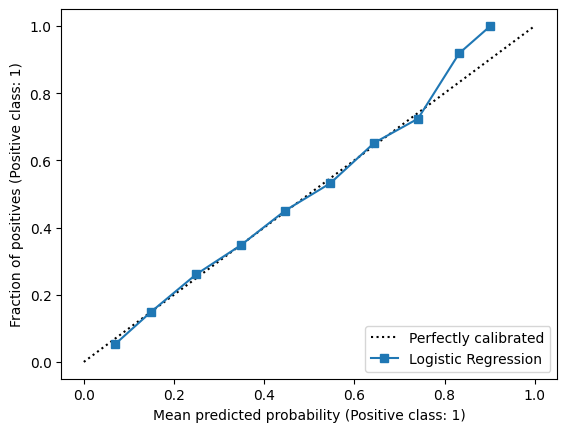

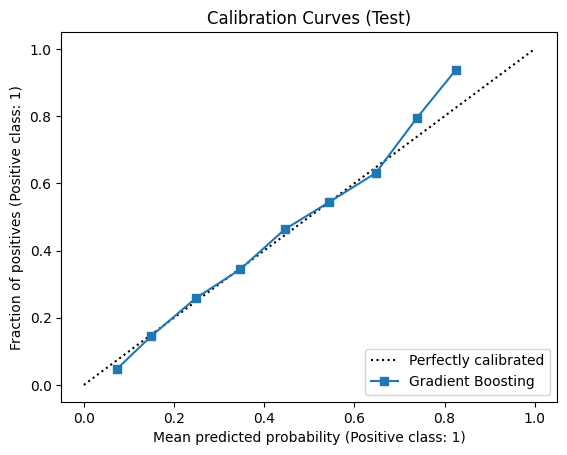

In [13]:
# === FEATURE SETUP ===
# Use everything EXCEPT the target 'churn' as X.
assert "churn" in churn.columns, "Expected a 'churn' column (0/1)."

X = churn.drop(columns="churn")
y = churn["churn"].astype(int)

# identify column types
possible_cats = ["gender", "plan", "topgenre", "secondgenre"]
categorical = [c for c in possible_cats if c in X.columns]

# treat "binary" 0/1 cols as numeric; everything else that's number-like is numeric
numeric = [c for c in X.columns if c not in categorical]

# build preprocessor to one-hot the categorical and scale numeric where useful
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numeric),  # sparse safe scaling
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ],
    remainder="drop"
)

# === TRAIN / TEST SPLIT (90/10, stratified) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# === MODELS ===
logit = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None, solver="lbfgs"))
])

gb = Pipeline([
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier(random_state=42))
])

models = {
    "Logistic Regression": logit,
    "Gradient Boosting": gb
}

def eval_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    # predicted probabilities for ROC AUC & calibration
    if hasattr(model, "predict_proba"):
        p_tr = model.predict_proba(Xtr)[:, 1]
        p_te = model.predict_proba(Xte)[:, 1]
    else:
        # fallback if decision_function exists
        p_tr = model.decision_function(Xtr)
        p_te = model.decision_function(Xte)

    yhat_tr = (p_tr >= 0.5).astype(int)
    yhat_te = (p_te >= 0.5).astype(int)

    metrics = {
        "train_acc": accuracy_score(ytr, yhat_tr),
        "train_prec": precision_score(ytr, yhat_tr, zero_division=0),
        "train_rec": recall_score(ytr, yhat_tr, zero_division=0),
        "train_auc": roc_auc_score(ytr, p_tr),
        "test_acc": accuracy_score(yte, yhat_te),
        "test_prec": precision_score(yte, yhat_te, zero_division=0),
        "test_rec": recall_score(yte, yhat_te, zero_division=0),
        "test_auc": roc_auc_score(yte, p_te),
        "brier_test": brier_score_loss(yte, p_te)
    }
    print(f"\n{name} RESULTS")
    print("-"*60)
    print(f"TRAIN -> Acc {metrics['train_acc']:.3f} | Prec {metrics['train_prec']:.3f} | "
          f"Rec {metrics['train_rec']:.3f} | AUC {metrics['train_auc']:.3f}")
    print(f"TEST  -> Acc {metrics['test_acc']:.3f} | Prec {metrics['test_prec']:.3f} | "
          f"Rec {metrics['test_rec']:.3f} | AUC {metrics['test_auc']:.3f} | "
          f"Brier {metrics['brier_test']:.3f}")
    return metrics, p_te, model

results = {}
probs_test = {}
fitted = {}

for name, m in models.items():
    metrics, p_te, mdl = eval_model(name, m, X_train, y_train, X_test, y_test)
    results[name] = metrics
    probs_test[name] = p_te
    fitted[name] = mdl

# pick best by TEST AUC
best_name = max(results, key=lambda k: results[k]["test_auc"])
best_model = fitted[best_name]
print(f"\nChosen model (by test AUC): {best_name}")

# === CALIBRATION (test set) ===
# Show calibration curves in the output cell so you can paste into your report.
try:
    import matplotlib.pyplot as plt
    plt.figure()
    for name in models.keys():
        CalibrationDisplay.from_predictions(
            y_test, probs_test[name], n_bins=10, name=name
        )
    plt.title("Calibration Curves (Test)")
    plt.show()
except Exception as e:
    print("Calibration plot skipped:", e)

## 2. Recommendation System

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# 1) Score new customers using the best model from the previous section
probs_new = best_model.predict_proba(new_customers)[:, 1]
new_scored = new_customers.copy()
new_scored["pred"] = probs_new

# 2) Select the top 200 high-risk customers
top_k = min(200, len(new_scored))
high_risk = new_scored.nlargest(top_k, "pred").copy()

# 3) Build KNN on the full churn dataset using key numeric features
knn_features = ["age", "income", "meanhourswatched"]

# Ensure these are numeric (in case of dtype issues)
for df in (churn, new_customers):
    df[knn_features] = df[knn_features].apply(pd.to_numeric, errors="coerce")

# Drop any rows in churn that have NaN in the KNN features
base_df = favorites.dropna(subset=knn_features).reset_index(drop=True)

# Scale features and fit KNN model
scaler_knn = StandardScaler()
base_X = scaler_knn.fit_transform(base_df[knn_features])

k = 10  # number of nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k, metric="euclidean")
nbrs.fit(base_X)

# Optional: use an ID column if available (otherwise indices)
id_col = None
for c in ["user_id", "customer_id", "id"]:
    if c in base_df.columns:
        id_col = c
        break

# 4) Find neighbors for each high-risk new customer
def neighbor_list(row):
    vec = scaler_knn.transform([row[knn_features].values])
    _, indices = nbrs.kneighbors(vec, n_neighbors=k)
    if id_col:
        return base_df.iloc[indices[0]][id_col].tolist()
    else:
        return indices[0].tolist()

high_risk["neighbors"] = high_risk.apply(neighbor_list, axis=1)

# 5) Display results like the example
display_cols = [
    "gender","age","income","monthssubbed","plan","meanhourswatched",
    "competitorsub","numprofiles","cancelled","downgraded","bundle","kids",
    "longestsession","topgenre","secondgenre","pred","neighbors"
]
high_risk[display_cols].head(6)

,gender,age,income,monthssubbed,plan,meanhourswatched,competitorsub,numprofiles,cancelled,downgraded,bundle,kids,longestsession,topgenre,secondgenre,pred,neighbors
42,woman,26.0,57.69,6,B,22.30,0,3,1,0,0,0,122.39,Comedy,Thriller,0.856308,"[209, 317, 416, 328, 268, 363, 307, 111, 445, ..."
339,woman,20.0,52.05,1,P,9.36,1,2,1,0,0,1,113.91,Thriller,ScienceFiction,0.842358,"[381, 307, 342, 328, 445, 8, 363, 370, 194, 197]"
217,woman,69.0,33.62,4,B,22.90,1,3,0,0,0,0,74.85,Drama,Comedy,0.820511,"[229, 481, 183, 89, 204, 187, 331, 81, 142, 364]"
228,woman,28.0,46.20,4,P,1.65,1,2,1,1,1,1,142.10,Comedy,Thriller,0.786036,"[194, 432, 8, 232, 377, 489, 342, 427, 306, 248]"
103,woman,39.0,52.25,21,B,29.91,1,1,1,0,0,0,70.09,Thriller,Documentary,0.767147,"[159, 19, 410, 140, 469, 114, 31, 41, 100, 245]"
419,woman,18.0,56.15,22,B,69.11,1,3,1,1,0,0,29.92,Drama,RomanticComedy,0.759070,"[442, 433, 76, 378, 240, 445, 209, 337, 44, 328]"
